In [24]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import torchvision 
from torchvision import models
# from torchvision.models.vision_transformer import Multi
from torchvision import datasets, models, transforms
from torchvision.transforms import functional as ff

import os.path as osp
from PIL import Image
import PIL.ImageEnhance as ImageEnhance

In [182]:
def vis_iou(y,out):
    sum = y.to('cpu')+out.to('cpu')
    return  torch.cat([
    y.to('cpu'),
    out.to('cpu'),
    (sum==2).type(torch.float),])
    
def center_crop(img, sz):
    s = torch.tensor(img.size()[-2:])
    ss = s.type(torch.float) - sz
    ss /= 2
    ss = ss.type(torch.int)

    return img[:,
        ss[0]:ss[0]+sz[0],
        ss[1]:ss[1]+sz[1]]

def seg_label_smooth(im, a):
    ### working only for square images
    ### may fix it for rectangle latter if would be needed
    s = im.size(-1)
    s1=int(round(s*1.1,0))
    s2=int(round(s1*1.2,0))
    print(im.size())
    print(s,s1,s2)
    yy1 = F.interpolate(im[0], size = (s1,s1))
    yy2 = F.interpolate(yy1, size = (s2,s2))
    
    return (a**(im[0]+center_crop(yy1[0],torch.tensor([64,64]))+center_crop(yy2[0],torch.tensor([64,64])))-1)/a**3

seg_label_smooth(y[0],2)


torch.Size([1, 64, 64])
64 70 84


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [] and output size of (70, 70). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [186]:
y[0,0]
# yy1 = F.interpolate(, size = (70,70))


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])

In [177]:
class FaceMask(Dataset):
    def __init__(self, rootpth, cropsize=(640, 480), mode='train', *args, **kwargs):
        super(FaceMask, self).__init__(*args, **kwargs)
        assert mode in ('train', 'val', 'test')
        self.mode = mode
        self.ignore_lb = 255
        self.rootpth = rootpth

        self.imgs = os.listdir(os.path.join(self.rootpth, 'CelebA-HQ-img'))

        #  pre-processing
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5,0.5),
            # (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize(size=[cropsize[0]//7,cropsize[1]//7]),
            transforms.CenterCrop((64,64)),
            ])
        self.to_tensor1 = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=[cropsize[0]//7,cropsize[1]//7]),
            transforms.CenterCrop((64,64)),
            transforms.Normalize(0.5,0.5)
            ])
        self.trans_train = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation([-30,30])
            ])

    def __getitem__(self, idx):
        impth = self.imgs[idx]
        img = Image.open(osp.join(self.rootpth, 'CelebA-HQ-img', impth))
        img = img.resize((512, 512), Image.BILINEAR)
        p = osp.join(self.rootpth, 'bin_mask', impth[:-3]+'png')
        if os.path.exists(p):
            label = Image.open(p).convert('P')

        # print(np.unique(np.array(label)))
        if self.mode == 'train':
            im_lb = dict(im=img, lb=label)
            img, label = im_lb['im'], im_lb['lb'] 
            seed = np.random.randint(1000000) # make a seed with numpy generator 
            torch.manual_seed(seed) # apply this seed to img transforms
            img = self.trans_train(img)
            torch.manual_seed(seed) # apply this seed to img transforms
            label = self.trans_train(label)
        img = self.to_tensor(img)
        label = np.array(label)
        label = self.to_tensor1(label)
        label +=1
        label /=2
        # label = seg_label_smooth(label, 2)
        label = torch.round(label)
        
        return img, label

    def __len__(self):
        return len(self.imgs)

In [178]:

ds = FaceMask('../CelebAMask-HQ/',mode='train')
train_loader = DataLoader(dataset=ds,
                          batch_size=128,
                          drop_last=True,
                          shuffle = True)
                          
img,y = next(iter(train_loader))
(y[0].size(),img[0].size())


(torch.Size([1, 64, 64]), torch.Size([3, 64, 64]))

torch.Size([1, 64, 64])


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [64] and output size of (70, 70). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [149]:
img1 = img.clone()
img1 += torch.randn(img1.size())/6
mn = img1.min()
img1[img1<-1]=-1
img1[img1>1]=1
y1 = y.clone()
y1 += torch.randn(y1.size())/5
y1 -= y1.min()
y1 /= y1.max()
y1 = torch.round(y1)

y2 = y.clone()
y2 += torch.randn(y1.size())/5
y2 -= y2.min()
y2 /= y2.max()
y2 = torch.round(y2)


In [ ]:
fig, ax = plt.subplots(10,10, figsize = (100,110))
a = y.clone()
a *= (-1)
for i in range(5):
    for j in range(10):
        ax[i,j].imshow(y[i+10*j].numpy().T )
        ax[i+5,j].imshow(a[i+10*j].numpy().T )
        # ax[i,j].imshow(vis_iou(y1[i+10*j],y2[i+10*j]).numpy().T )

In [ ]:
def block_down(inc,outc,mid_big=False,kern_size_desc=True):
    
    mid = 0
    if mid_big: mid=outc
    else: mid=inc

    if kern_size_desc:
        c1 = nn.Conv2d(inc,mid,4,2,1)
        c2 = nn.Conv2d(mid,outc,3,1,1)
        
    else:
        c1 = nn.Conv2d(inc,mid,3,1,1)
        c2 = nn.Conv2d(mid,outc,4,2,1)
        
    return nn.Sequential(
        c1,
        nn.BatchNorm2d(mid),
        nn.LeakyReLU(),
        c2,
        nn.BatchNorm2d(outc),
        nn.LeakyReLU(),
        )

def block_up(inc,outc,mid_big=True,kern_size_desc=False):
    
    mid = 0
    if mid_big: mid=outc
    else: mid=inc
    
    if kern_size_desc:
        c1 = nn.ConvTranspose2d(inc,mid,4,2,1)
        c2 = nn.ConvTranspose2d(mid,outc,3,1,1)
        
    else:
        c1 = nn.ConvTranspose2d(inc,mid,3,1,1)
        c2 = nn.ConvTranspose2d(mid,outc,4,2,1)
        
    
    return nn.Sequential(
        c1,
        nn.BatchNorm2d(mid),
        nn.LeakyReLU(),
        c2,
        nn.BatchNorm2d(outc),
        nn.LeakyReLU(),
        )
        

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

In [ ]:
#for img 3x16x16 pxl
class UNET_2_atten(nn.Module):
    def __init__(self,num_channels=3):
        super().__init__()
        
        self.from_img = nn.Conv2d(3,2**3,3,1,1)
        self.to_img = nn.ConvTranspose2d(2**3,num_channels,3,1,1)

        #encoder layers
        self.enc1 = nn.ModuleList([block_down(2**(i+1),2**(i+2)) for i in range(2,6+2)])
        #decoder layers
        self.ct2 = block_up(128*4,64*4)
        self.dec2 = nn.ModuleList([block_up(2**(i+3),2**(i+1)) for i in range(2,5+2)])
        # self.bottle_neck_down = nn.Linear(512,128)
        # self.bottle_neck_up = nn.Linear(128,512)
        self.skip = []
        self.soft = nn.Softmax()
        self.atten = nn.ModuleList([Attention_block(2**(i+2),2**(i+2),4) for i in range(2,5+2)])
        self.bottle_neck_down = nn.Linear(512,128)
        self.bottle_neck_up = nn.Linear(128,512)

    def enc(self, x):
        for i in self.enc1:
            x = i(x)
            self.skip.append(x)
        return x
        
    def dec(self, x):
        x = self.ct2(x)
        for k,(i,j) in enumerate(zip(self.dec2[::-1],self.atten[::-1])):
            d = j(x,self.skip[::-1][k+1])
            x = torch.cat((x,d),axis=1)
            x = i(x)
        return x

    def forward(self, x):
        self.skip = []
        x = self.from_img(x)

        x = self.enc(x)    

        x = self.bottle_neck_down(nn.Flatten()(x))
        x = self.bottle_neck_up(x)
        x = self.dec(x.resize(x.size()[0],512,1,1))    
        # x = self.dec(x)
        
        x = self.to_img(x)
        return self.soft(x)
#for img 3x16x16 pxl
u = UNET_2_atten()
u(torch.randn(3,3,64,64)).size()


/home/michal/anaconda3/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_738/2110791199.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


torch.Size([3, 3, 64, 64])

In [ ]:
#for img 3x16x16 pxl
class UNET_2_1(nn.Module):
    def __init__(self,num_channels=3):
        super().__init__()
        
        self.from_img = nn.Conv2d(3,2**5,3,1,1)
        self.to_img = nn.ConvTranspose2d(2**5,num_channels,3,1,1)

        #encoder layers
        self.enc1 = nn.ModuleList([block_down(2**(i+1),2**(i+2)) for i in range(2+2,6+2)])
        #decoder layers
        self.ct2 = block_up(128*4,64*4)
        self.dec2 = nn.ModuleList([block_up(2**(i+2),2**(i+1)) for i in range(2+2,5+2)])
        # self.bottle_neck_down = nn.Linear(512,128)
        # self.bottle_neck_up = nn.Linear(128,512)
        self.skip = []
        self.soft = nn.Softmax()

    def enc(self, x):
        for i in self.enc1:
            x = i(x)
            self.skip.append(x)
        return x
        
    def dec(self, x):
        x = self.ct2(x)
        for k,i in enumerate(self.dec2[::-1]):
            x += self.skip[::-1][k+1]
            x = i(x)
        return x

    def forward(self, x):
        self.skip = []
        x = self.from_img(x)

        x = self.enc(x)    

        # x = self.bottle_neck_down(nn.Flatten()(x))
        # x = self.bottle_neck_up(x)
        # x = self.dec(x.resize(x.size()[0],512,1,1))    
        x = self.dec(x)
        
        x = self.to_img(x)
        return self.soft(x)

u = UNET_2_1()
u(torch.randn(5,3,16,16)).size()

/tmp/ipykernel_738/1657324916.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


torch.Size([5, 3, 16, 16])

In [ ]:
#for img 3x32x32 pxl
class UNET_2_2(nn.Module):
    def __init__(self,num_channels=3,unet = UNET_2_1()):
        super().__init__()
        
        self.from_img = nn.Conv2d(3,2**4,3,1,1)
        self.to_img = nn.ConvTranspose2d(2**4,num_channels,3,1,1)

        #encoder layers
        self.enc1 =  unet.enc1[::-1]
        self.enc1.append(block_down(2**(4),2**(5)
                         ,mid_big=True, kern_size_desc=False))
        self.enc1 =  self.enc1[::-1]
        #decoder layers
        self.ct2 = block_up(128*4,64*4)
        # self.ct2 = block_up(128*2,64*2)
        self.dec2 =  unet.dec2[::-1]
        self.dec2.append(block_up(2**(5),2**(4)
                         ,mid_big=False, kern_size_desc=True))
        self.dec2 =  self.dec2[::-1]
                               
        #decoder layers
        self.skip = []
        self.soft = nn.Softmax()

    def enc(self, x):
        for i in self.enc1:
            x = i(x)
            self.skip.append(x)
        return x
        
    def dec(self, x):
        x = self.ct2(x)
        for k,i in enumerate(self.dec2[::-1]):
            x += self.skip[::-1][k+1]
            x = i(x)
        return x

    def forward(self, x):
        self.skip = []
        x = self.from_img(x)
        print(x.size())

        x = self.enc(x)    

        # x = self.bottle_neck_down(nn.Flatten()(x))
        # x = self.bottle_neck_up(x)
        # x = self.dec(x.resize(x.size()[0],512,1,1))    
        x = self.dec(x)
        
        x = self.to_img(x)
        return self.soft(x)

u = UNET_2_2()
u(torch.randn(5,3,32,32)).size()

torch.Size([5, 16, 32, 32])


/tmp/ipykernel_738/1357336131.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


torch.Size([5, 3, 32, 32])

In [ ]:
#for img 3x32x32 pxl
class UNET_2_3(nn.Module):
    def __init__(self,num_channels=3,unet = UNET_2_2()):
        super().__init__()
        
        self.from_img = nn.Conv2d(3,2**3,3,1,1)
        self.to_img = nn.ConvTranspose2d(2**3,num_channels,3,1,1)

        #encoder layers
        self.enc1 =  unet.enc1[::-1]
        self.enc1.append(block_down(2**(3),2**(4),mid_big=True, kern_size_desc=False))
        self.enc1 =  self.enc1[::-1]
        #decoder layers
        self.ct2 = block_up(128*4,64*4)
        # self.ct2 = block_up(128*2,64*2)
        self.dec2 =  unet.dec2[::-1]
        self.dec2.append(block_up(2**(4),2**(3),mid_big=False, kern_size_desc=True))
        self.dec2 =  self.dec2[::-1]
        self.bottle_neck_down = nn.Linear(512,128)
        self.bottle_neck_up = nn.Linear(128,512)

        #decoder layers
        self.skip = []
        self.soft = nn.Softmax()

    def enc(self, x):
        for i in self.enc1:
            x = i(x)
            self.skip.append(x)
        return x
        
    def dec(self, x):
        x = self.ct2(x)
        for k,i in enumerate(self.dec2[::-1]):
            x += self.skip[::-1][k+1]
            x = i(x)
        return x

    def forward(self, x):
        self.skip = []
        x = self.from_img(x)

        x = self.enc(x)    
        x = self.bottle_neck_down(nn.Flatten()(x))
        x = self.bottle_neck_up(x)
        x = self.dec(x.reshape(x.size()[0],512,1,1))
        
        x = self.to_img(x)
        return self.soft(x)

u = UNET_2_3().to('cuda:0')
u(torch.randn(5,3,64,64).to('cuda:0')).size()

/tmp/ipykernel_738/388140491.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


torch.Size([5, 3, 64, 64])

In [ ]:
def vis_iou(y,out):
    sum = y.to('cpu')+out.to('cpu')
    return  torch.cat([
    y.to('cpu'),
    out.to('cpu'),
    (sum==2).type(torch.float),
    ]
    )


In [ ]:
def train_unet_M(num_epochs, model, optimizer, device, 
                 train_loader, loss_fn=None,
                 logging_interval=100,batchsize=128,
                 save_model=None,two_chan=True):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, y) in enumerate(train_loader):

            features = features.to(device[0])
            y = y.to(device[0]).type(torch.float)
            if two_chan==True:
                y += 1
                y /= 2
                a = y.clone()
                a *= -1
                a +=  1
                y = torch.round(torch.cat([a,y],axis=1))
                
            # FORWARD AND BACK PROP
            decoded = model(features)

            pixelwise = loss_fn(decoded, y.to('cuda:0'), reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            loss = pixelwise.mean().to('cuda:0') # average over batch dimension
            
            optimizer.zero_grad()
            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            # log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            # log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        img = decoded.detach().cpu()
        # .numpy()
        img1 = features.detach().cpu().numpy()
        for i in range(5):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i+5].imshow(vis_iou(y[i+10*j][[0]],img[i+10*j][[0]]).T)
        plt.show()
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [16]:
def train_unet_M_noiss_11(num_epochs, model, optimizer, device, 
                        train_loader, loss_fn=None,
                        logging_interval=100,batchsize=128,
                        save_model=None,two_chan=True):
    
    log_dict = {'train_combined_loss_per_batch': [],
                'train_combined_loss_per_epoch': [],
                'train_reconstruction_loss_per_batch': [],
                'train_kl_loss_per_batch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, y) in enumerate(train_loader):

            features = features.to(device[0])
            features += torch.randn(features.size()).to(device[0])
            y = y.to(device[0]).type(torch.float)
            if two_chan==True:
                a = y.clone()
                a *= -1
                a +=  1
                y = torch.cat([a,y],axis=1)
                
            # FORWARD AND BACK PROP
            decoded = model(features)

            pixelwise = loss_fn(decoded, y.to('cuda:0'), reduction='none')
            pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
            loss = pixelwise.mean().to('cuda:0') # average over batch dimension
            
            optimizer.zero_grad()
            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_combined_loss_per_batch'].append(loss.item())
            # log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
            # log_dict['train_kl_loss_per_batch'].append(kl_div.item())
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        fig, ax = plt.subplots(10,10, figsize=(64, 48))
        img = decoded.detach().cpu()
        # .numpy()
        img1 = features.detach().cpu().numpy()
        for i in range(5):
            for j in range(10):
                ax[j,i].imshow(img1[i+10*j].T)
                ax[j,i+5].imshow(vis_iou(y[i+10*j][[0]],img[i+10*j][[0]]).T)
        plt.show()
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict

In [ ]:
# def train_unet_M(num_epochs, model, optimizer, device, 
#                  train_loader, test_loader, loss_fn=None,
#                  logging_interval=100,batchsize=128,
#                  save_model=None,two_chan=True):
    
#     log_dict = {'train_combined_loss_per_batch': [],
#                 'train_combined_loss_per_epoch': [],
#                 'train_reconstruction_loss_per_batch': [],
#                 'train_kl_loss_per_batch': []}

#     if loss_fn is None:
#         loss_fn = F.binary_cross_entropy

#     start_time = time.time()
#     for epoch in range(num_epochs):

#         model.train()
#         for batch_idx, (features, y) in enumerate(train_loader):

#             features = features.to(device[0])
#             y = y.to(device[0]).type(torch.float)
#             if two_chan==True:
#                 a = y.clone()
#                 a *= -1
#                 a +=  1
#                 y = torch.cat([a,y],axis=1)
                
#             # FORWARD AND BACK PROP
#             decoded = model(features)

#             pixelwise = loss_fn(decoded, y.to('cuda:0'), reduction='none')
#             pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
#             loss = pixelwise.mean().to('cuda:0') # average over batch dimension
            
#             optimizer.zero_grad()
#             loss.backward()

#             # UPDATE MODEL PARAMETERS
#             optimizer.step()

#             # LOGGING
#             log_dict['train_combined_loss_per_batch'].append(loss.item())
#             # log_dict['train_reconstruction_loss_per_batch'].append(pixelwise.item())
#             # log_dict['train_kl_loss_per_batch'].append(kl_div.item())
#             if not batch_idx % logging_interval:
#                 print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
#                       % (epoch+1, num_epochs, batch_idx,
#                           len(train_loader), loss))
#             break
#         print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
#         with torch.no_grad():
#             for batch_idx, (features, y) in enumerate(train_loader):

#                 features = features.to(device[0])
#                 y = y.to(device[0]).type(torch.float)
#                 if two_chan==True:
#                     a = y.clone()
#                     a *= -1
#                     a +=  1
#                     y = torch.cat([a,y],axis=1)
                    
#                 # FORWARD AND BACK PROP
#                 decoded = model(features)

#                 pixelwise = loss_fn(decoded, y.to('cuda:0'), reduction='none')
#                 pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
#                 loss = pixelwise.mean().to('cuda:0') # average over batch dimension
#                 s += loss
#             s/=batch_idx+1
#             print('train loss:'+str(s))
#             fig, ax = plt.subplots(10,10, figsize=(64, 48))
#             img = decoded.detach().cpu()
#             # .numpy()
#             img1 = features.detach().cpu().numpy()
#             for i in range(5):
#                 for j in range(10):
#                     ax[j,i].imshow(img1[i+10*j].T)
#                     ax[j,i+5].imshow(vis_iou(y[i+10*j][[0]],img[i+10*j][[0]]).T)
#             plt.show()
    
#     print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
#     if save_model is not None:
#         torch.save(model.state_dict(), save_model)
    
#     return log_dict

/home/michal/anaconda3/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/michal/anaconda3/lib/python3.10/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/tmp/ipykernel_738/2110791199.py:48: UserWarning: Implicit dimension choice for softmax has been depr

Epoch: 001/001 | Batch 0000/0234 | Loss: 4008.0210
Epoch: 001/001 | Batch 0050/0234 | Loss: 3876.3242
Epoch: 001/001 | Batch 0100/0234 | Loss: 3534.5527
Epoch: 001/001 | Batch 0150/0234 | Loss: 3675.6504
Epoch: 001/001 | Batch 0200/0234 | Loss: 3437.1226
Time elapsed: 14.50 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

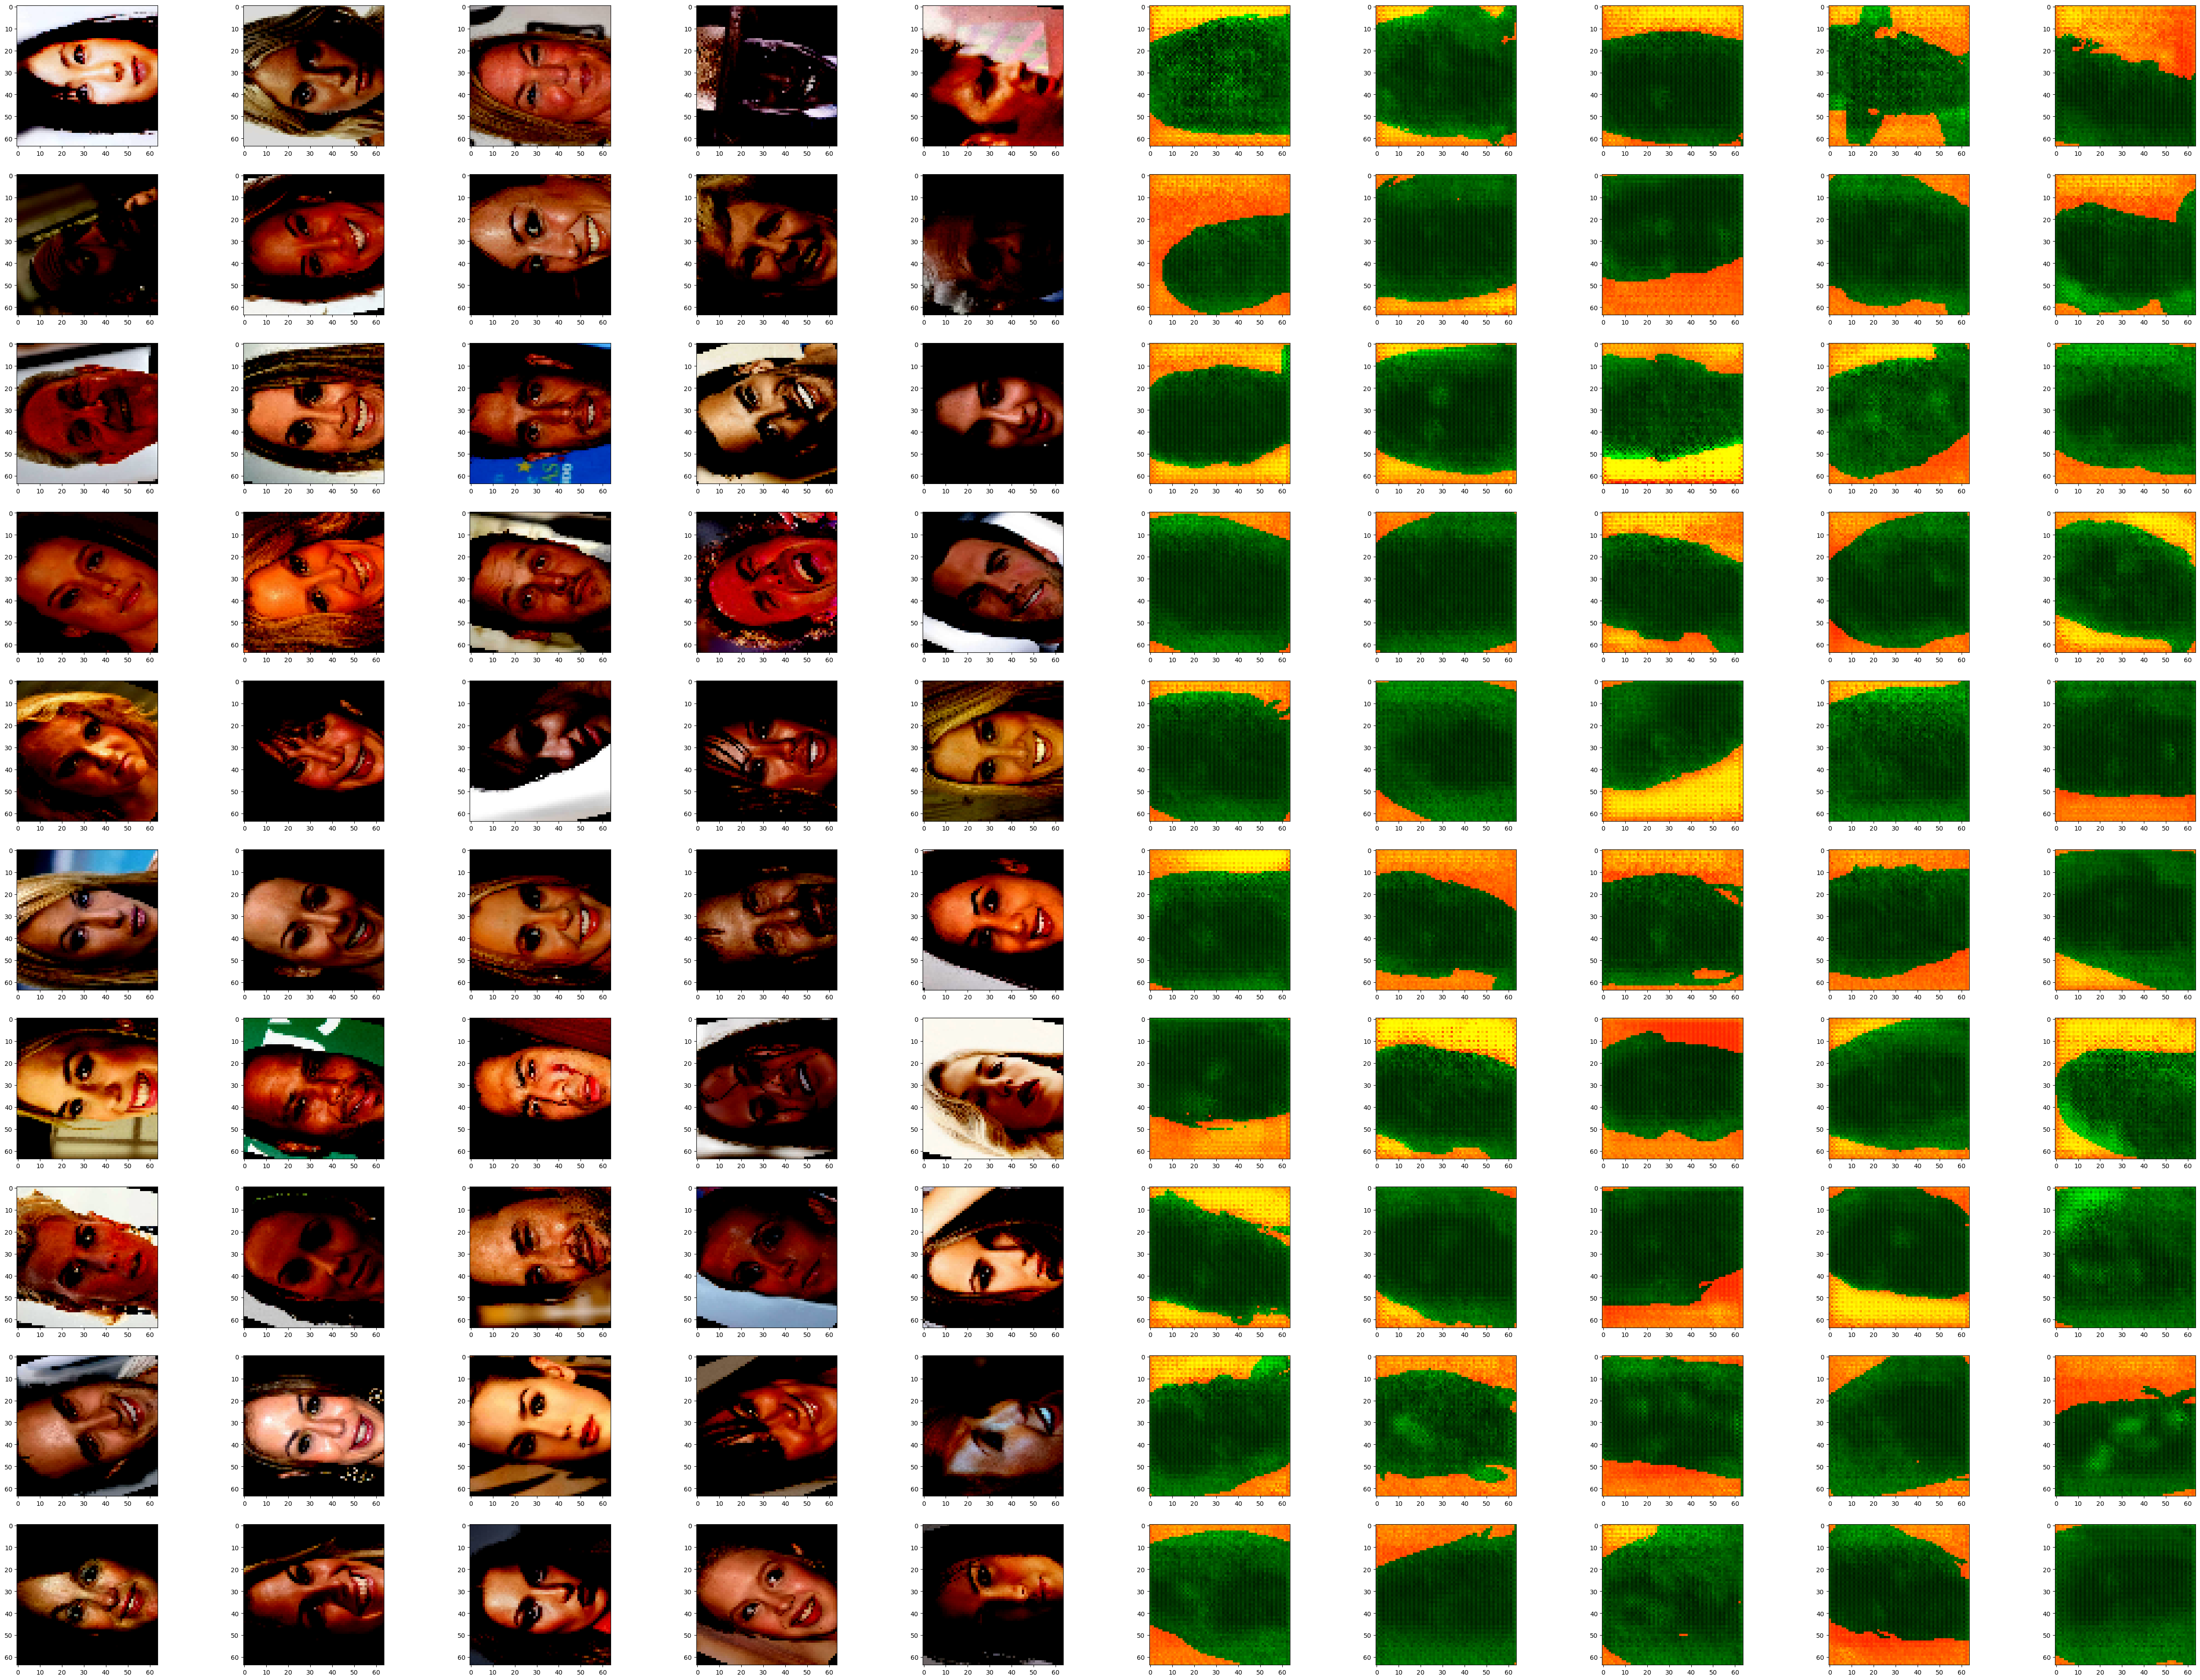

Total Training Time: 14.71 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [29]:
# torch.autograd.set_detect_anomaly(True)
# NUM_EPOCHS=2
# DEVICE = ['cuda:0','cuda:0']
# LEARNING_RATE = 0.0001
# model=UNET_2_atten(num_channels=2).to('cuda:0')
# model.load_state_dict(torch.load('./unet_2_3_e7.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)    
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.001,cycle_momentum=False)
log_dict1 = train_unet_M(num_epochs=1, model=model,
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')

# torch.save(model.state_dict(),'./unet_2_3_e7.pt')


/tmp/ipykernel_429/2110791199.py:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


Epoch: 001/001 | Batch 0000/0234 | Loss: 6527.6387
Epoch: 001/001 | Batch 0050/0234 | Loss: 5672.6924
Epoch: 001/001 | Batch 0100/0234 | Loss: 4802.1963
Epoch: 001/001 | Batch 0150/0234 | Loss: 3175.7998
Epoch: 001/001 | Batch 0200/0234 | Loss: 1482.5829
Time elapsed: 31.04 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

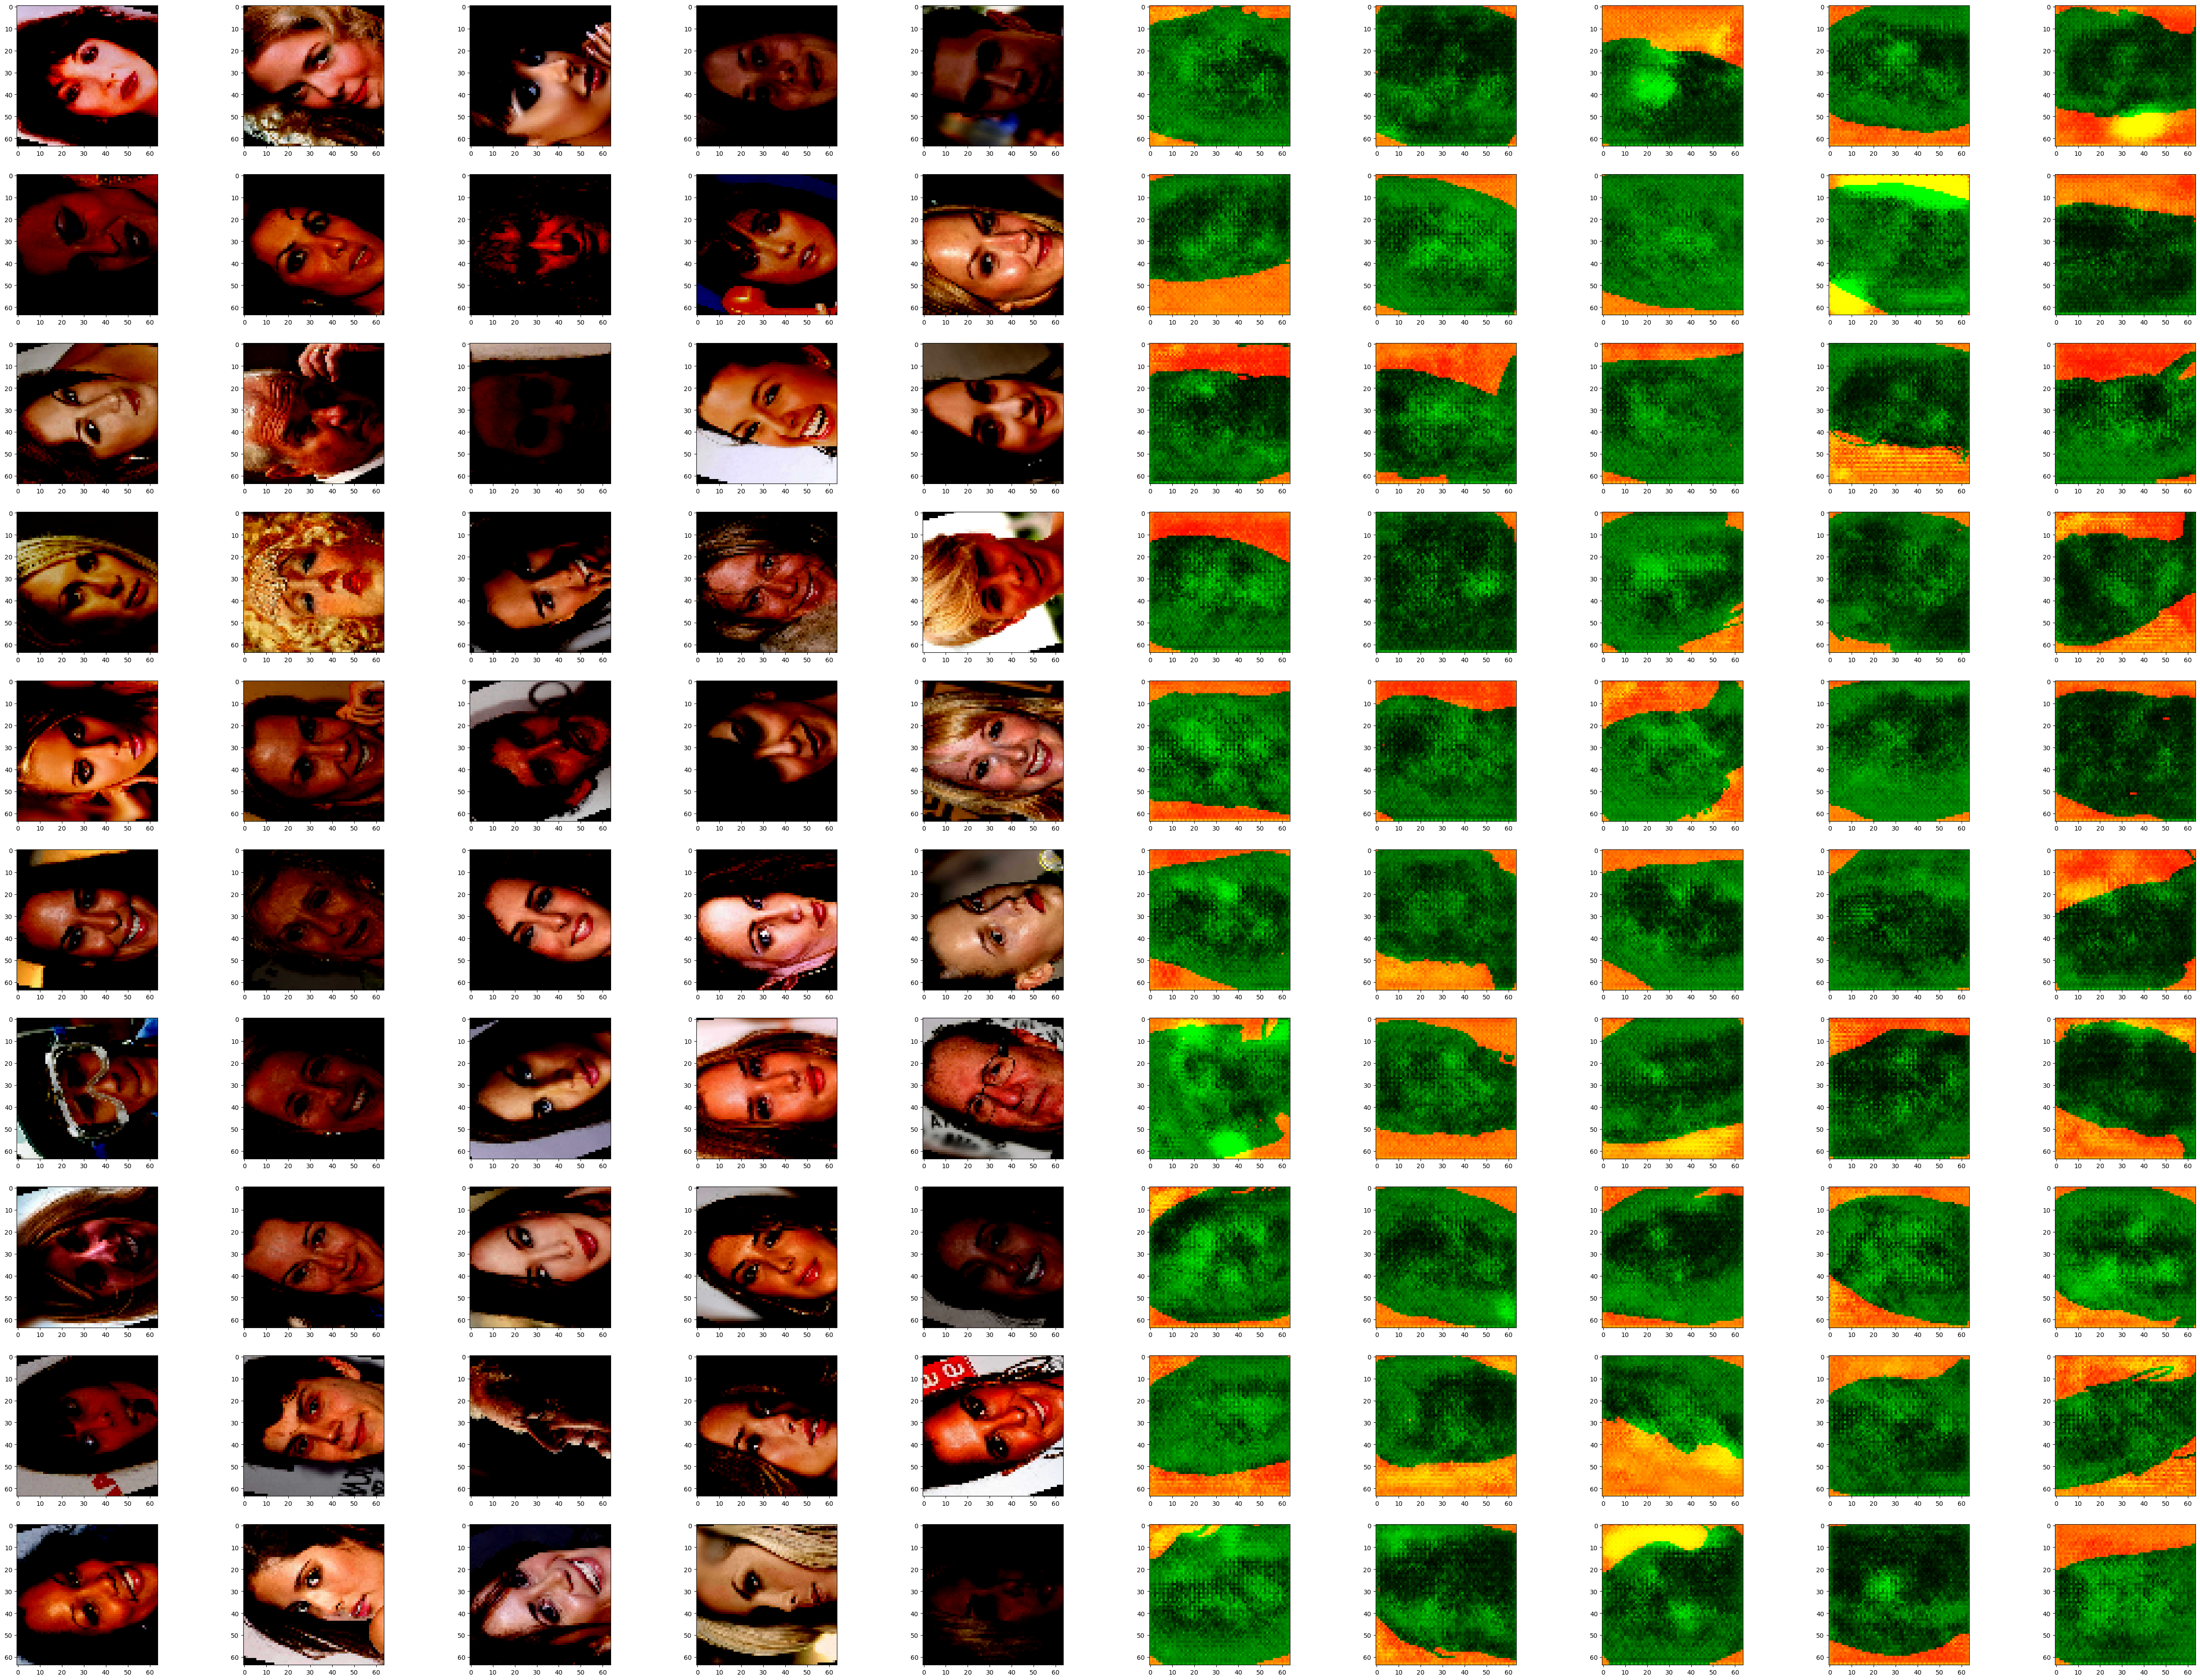

Total Training Time: 31.24 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [47]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=2
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=UNET_2_atten(num_channels=2).to('cuda:0')
# model.load_state_dict(torch.load('./unet_2_3_e7.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)    
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.00001, max_lr=0.001,cycle_momentum=False)
log_dict1 = train_unet_M(num_epochs=1, model=model,
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')

# torch.save(model.state_dict(),'./unet_2_3_e7.pt')


/tmp/ipykernel_738/388140491.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)


Epoch: 001/003 | Batch 0000/0234 | Loss: 2949.1016
Epoch: 001/003 | Batch 0050/0234 | Loss: 2000.5768
Epoch: 001/003 | Batch 0100/0234 | Loss: 1747.8223
Epoch: 001/003 | Batch 0150/0234 | Loss: 1685.8727
Epoch: 001/003 | Batch 0200/0234 | Loss: 1656.3374
Time elapsed: 14.51 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

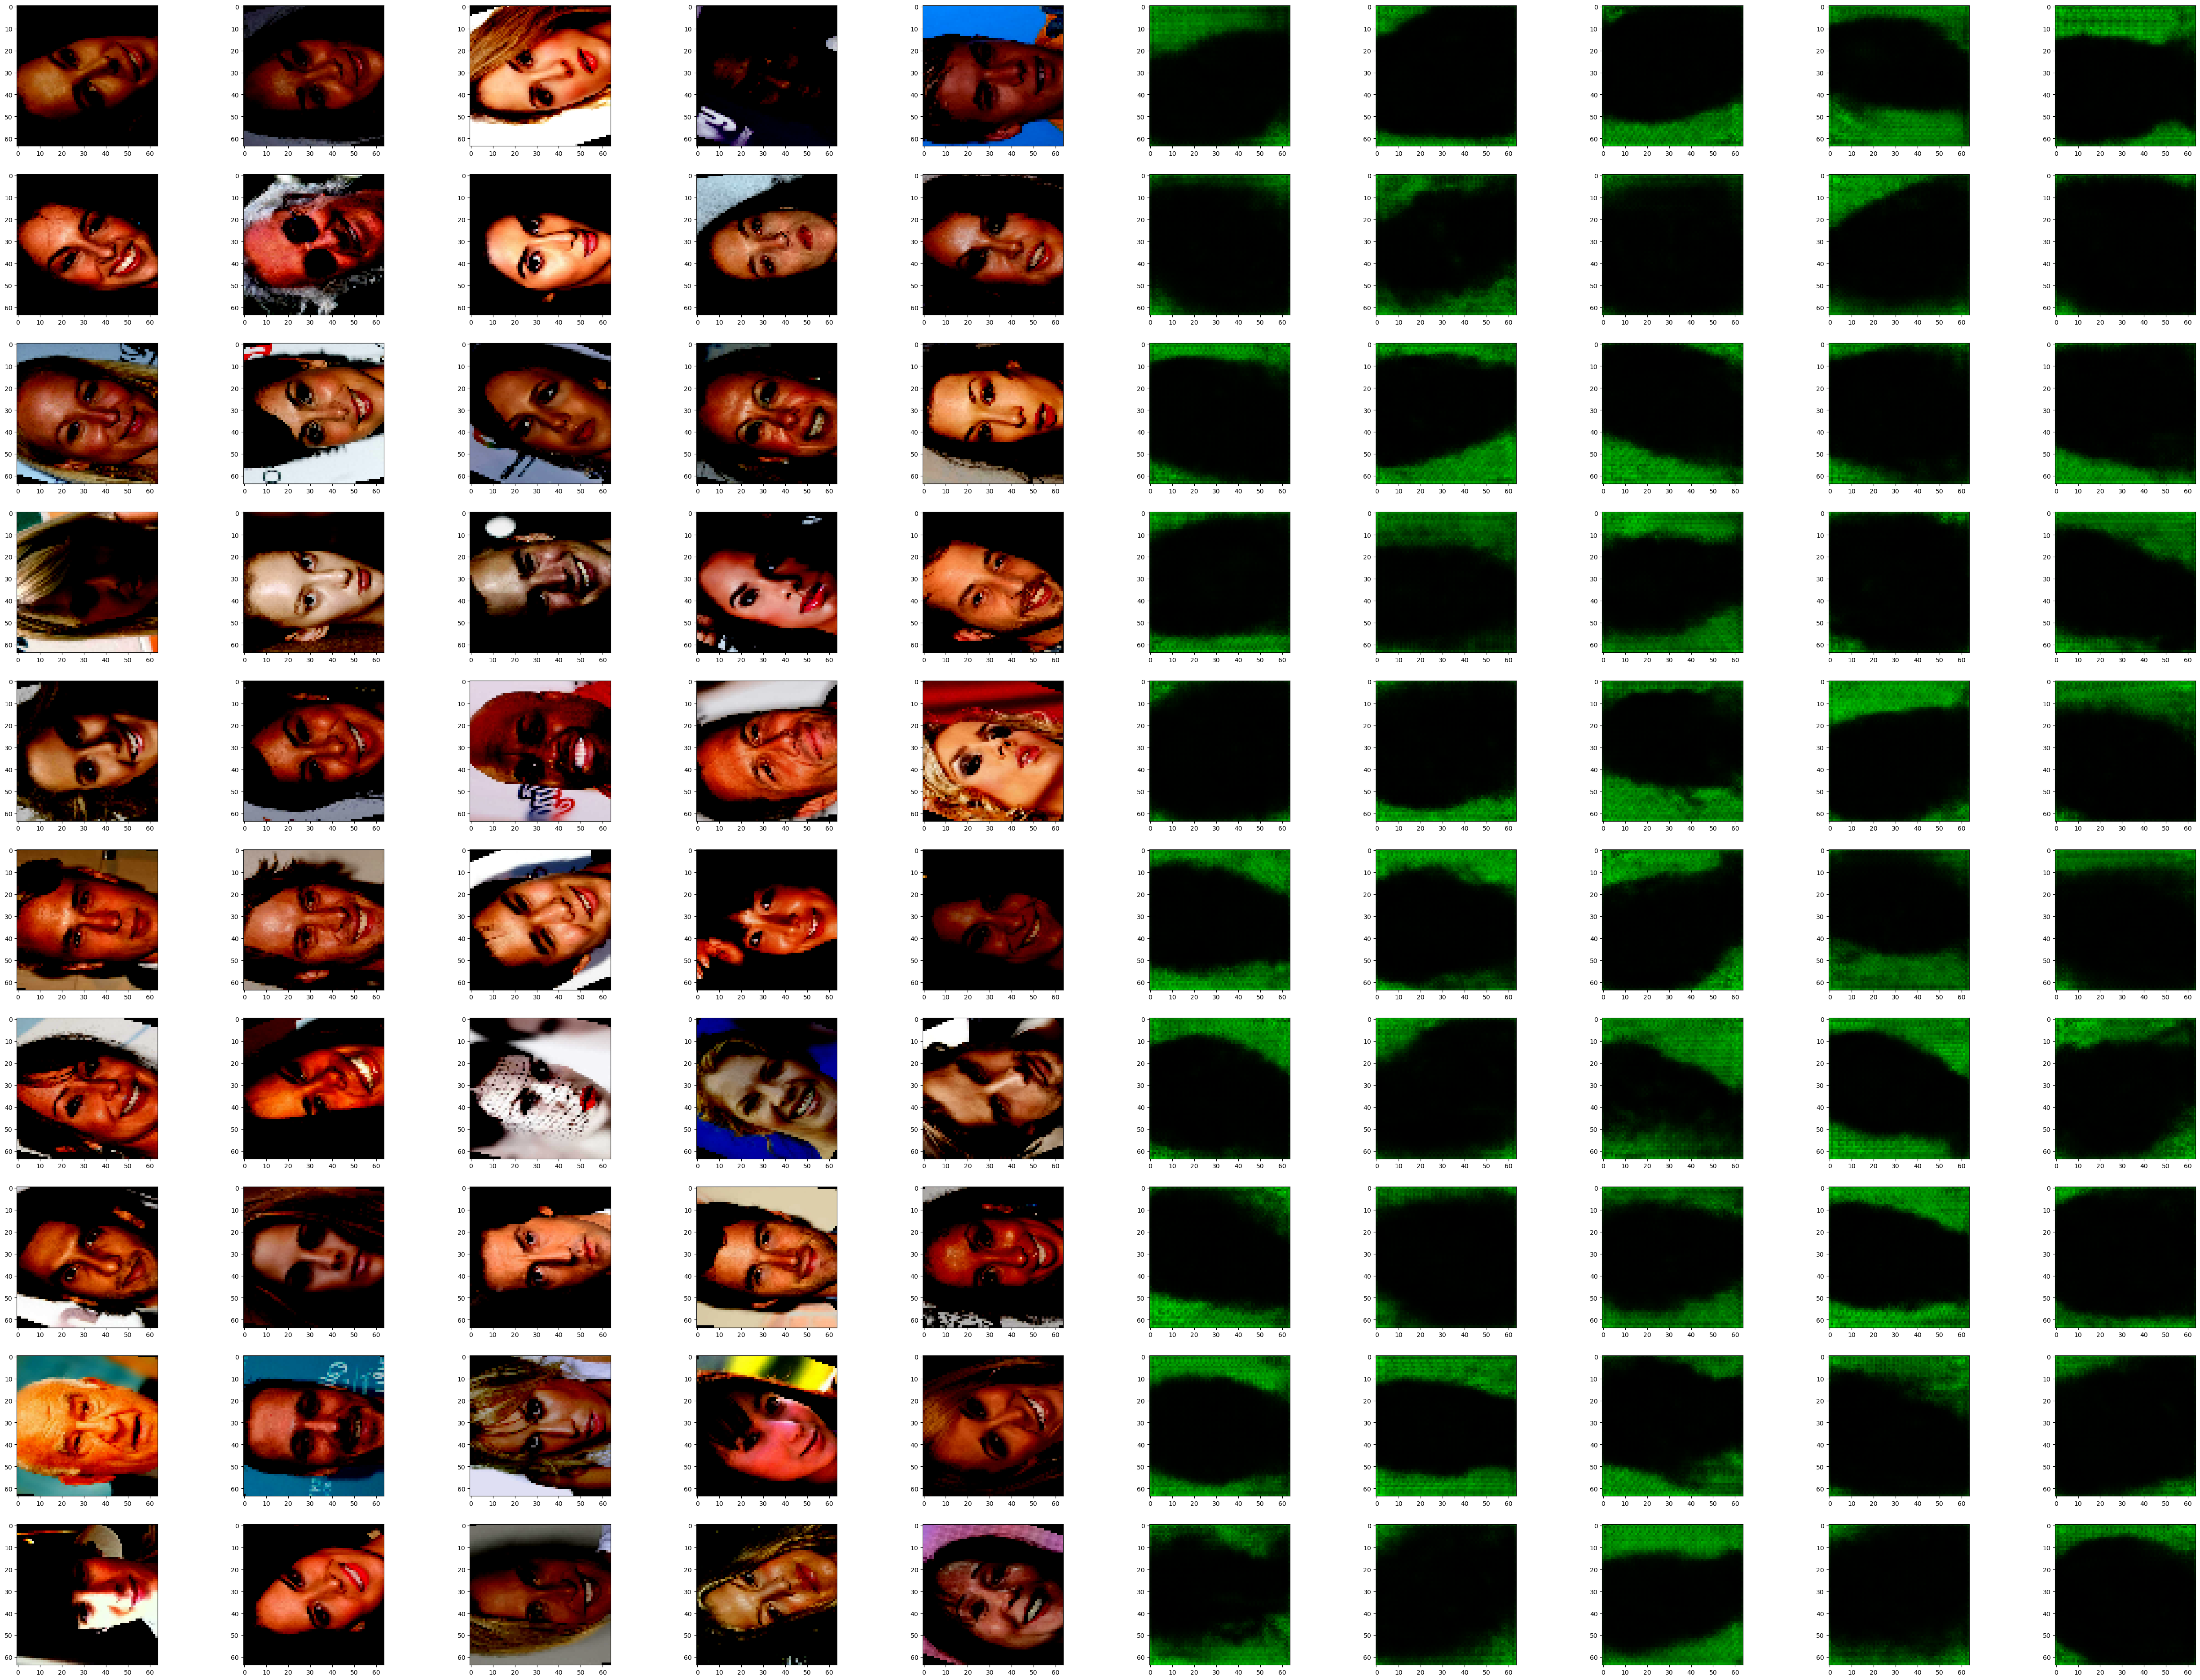

Epoch: 002/003 | Batch 0000/0234 | Loss: 1603.5371
Epoch: 002/003 | Batch 0050/0234 | Loss: 1555.6559
Epoch: 002/003 | Batch 0100/0234 | Loss: 1716.9396
Epoch: 002/003 | Batch 0150/0234 | Loss: 1627.5851
Epoch: 002/003 | Batch 0200/0234 | Loss: 1609.7098
Time elapsed: 29.00 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

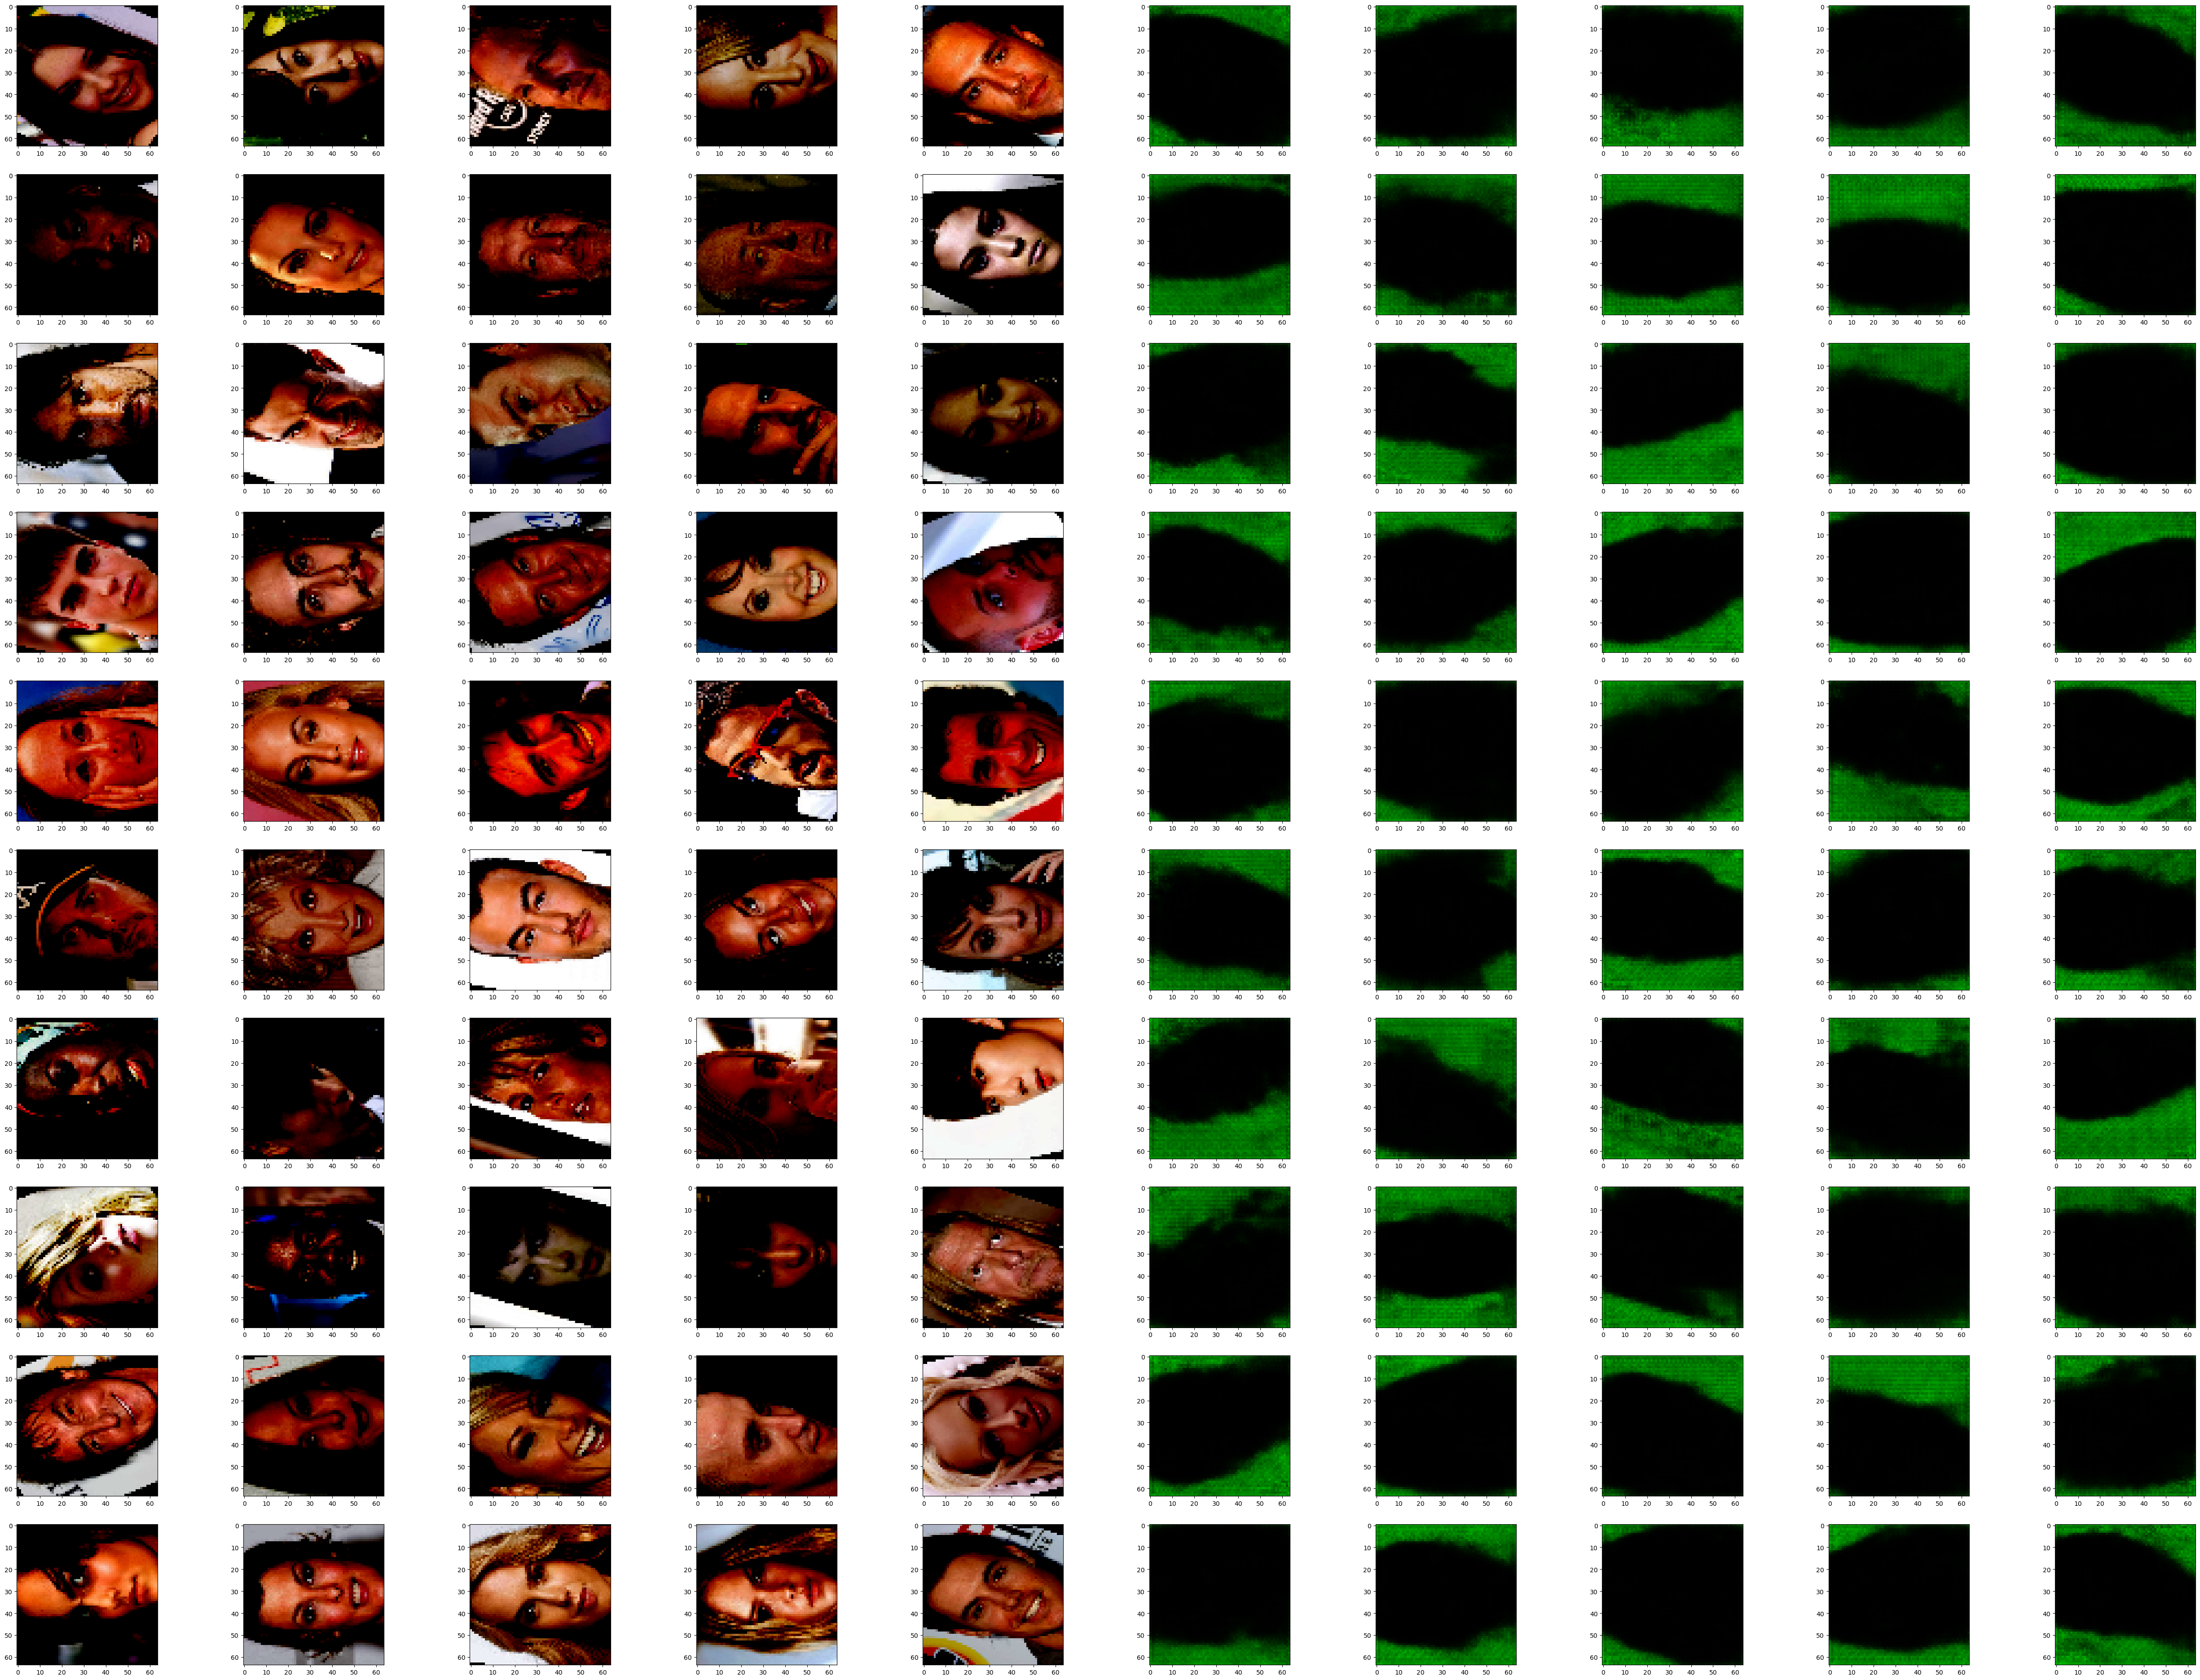

Epoch: 003/003 | Batch 0000/0234 | Loss: 1528.9514
Epoch: 003/003 | Batch 0050/0234 | Loss: 1539.9077
Epoch: 003/003 | Batch 0100/0234 | Loss: 1524.6002
Epoch: 003/003 | Batch 0150/0234 | Loss: 1522.7708
Epoch: 003/003 | Batch 0200/0234 | Loss: 1630.0281
Time elapsed: 44.27 min


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

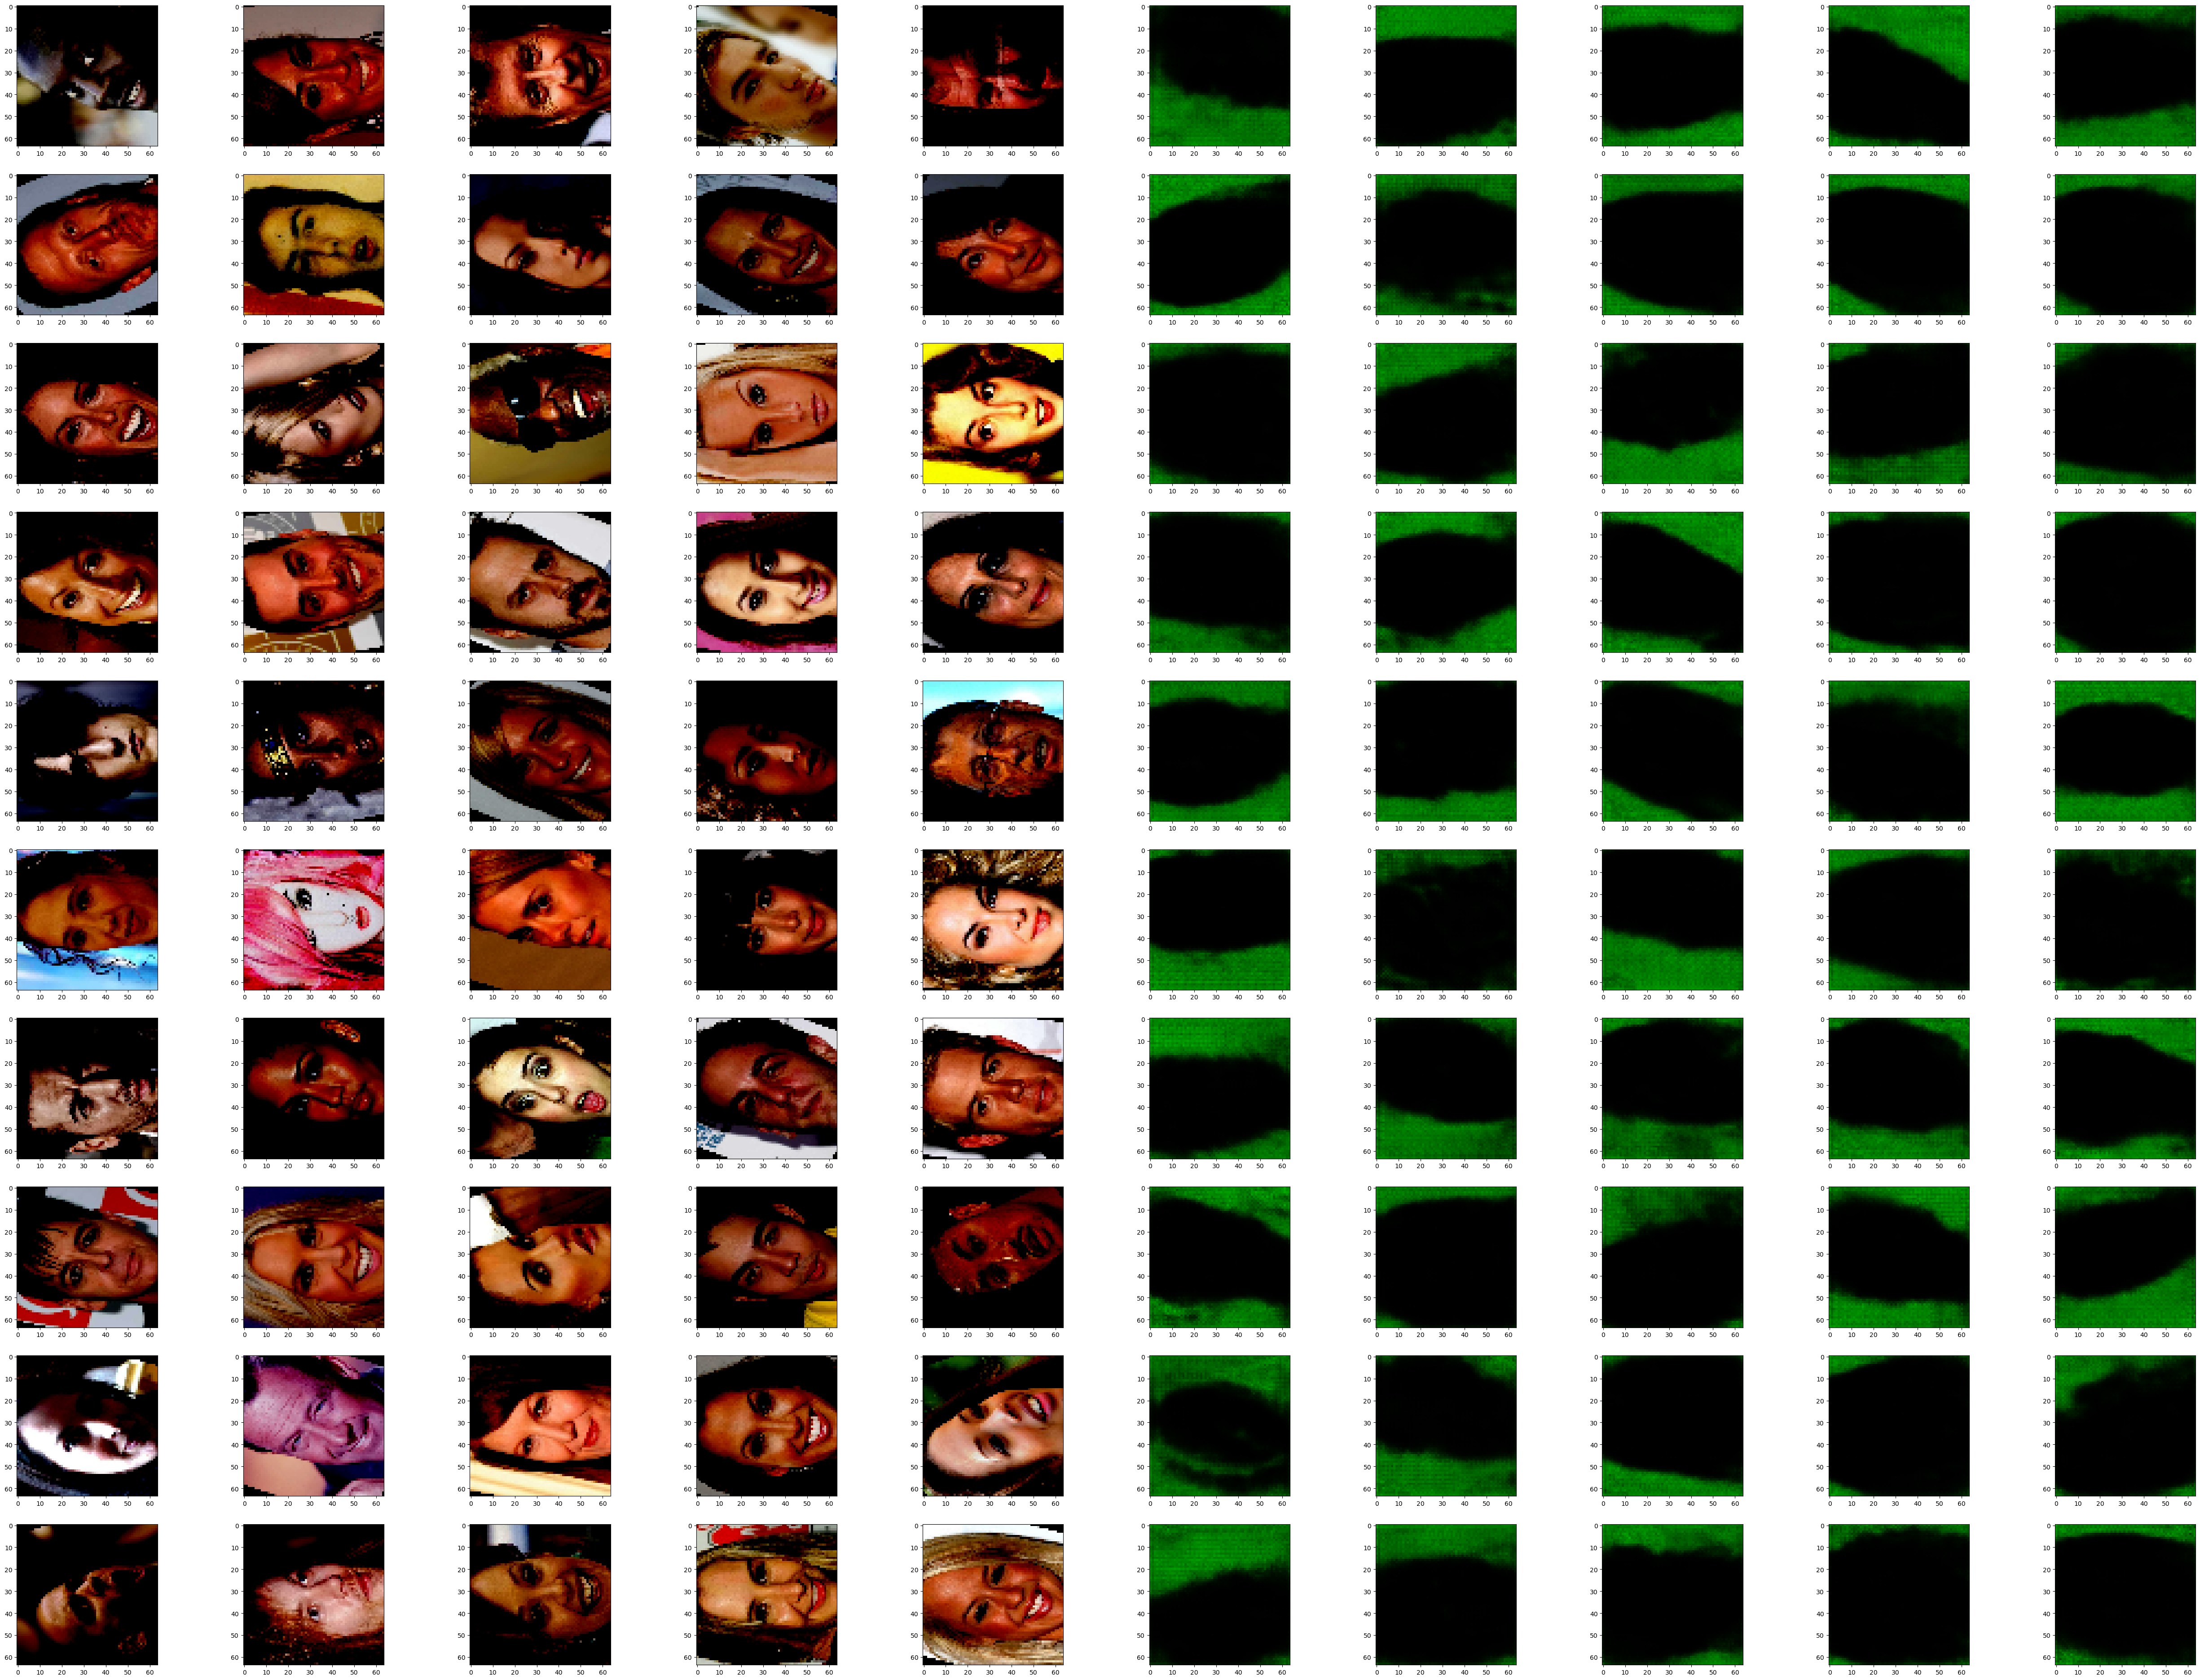

Total Training Time: 44.48 min
END OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAEEND OF VAE


In [32]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS=3
DEVICE = ['cuda:0','cuda:0']
LEARNING_RATE = 0.0001
model=UNET_2_3(num_channels=2).to('cuda:0')
model.load_state_dict(torch.load('./unet_2_3_e7.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)    
log_dict1 = train_unet_M(num_epochs=NUM_EPOCHS, model=model,
                        optimizer=optimizer, device=['cuda:0','cuda:0'], 
                        train_loader=train_loader,
                        logging_interval=50)
print(20*'=')
print(20*'END OF VAE')
print(20*'=')

torch.save(model.state_dict(),'./unet_2_3_e3_bottom.pt')


(torch.Size([128, 1, 64, 64]),
 torch.Size([128, 1, 64, 64]),
 torch.Size([128, 1, 64, 64]))

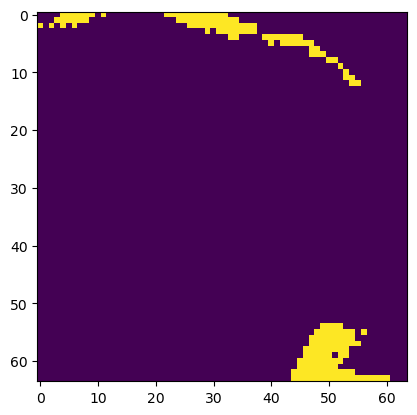

In [ ]:
plt.imshow(
    # ((sum[0]!=1)*(img3.to('cpu')[0]!=1)).type(torch.int).T
    ((sum[0]!=1)*(y.to('cpu')[0]==1)).type(torch.int).T

)    
(y.size(),
img3.size(),
sum.size())

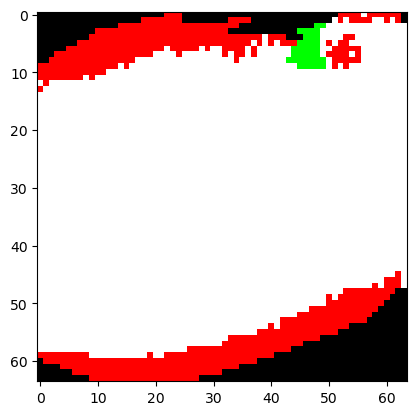

In [21]:
def vis_iou(y,out):
    sum = y.to('cpu')+out.to('cpu')
    
    return  torch.cat([
    y.to('cpu'),
    out.to('cpu'),
    (sum==2).type(torch.float),
    # ((sum[0]!=1)*(y.to('cpu')==1)).type(torch.float),
    # ((sum[0]!=1)*(out.to('cpu')!=1)==0).type(torch.float),
    ]
    )

plt.imshow(vis_iou(y[0],img2[0][[1]]).T)


In [ ]:
img2[0,[0]].size()

torch.Size([1, 64, 64])

/tmp/ipykernel_738/388140491.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.soft(x)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow w

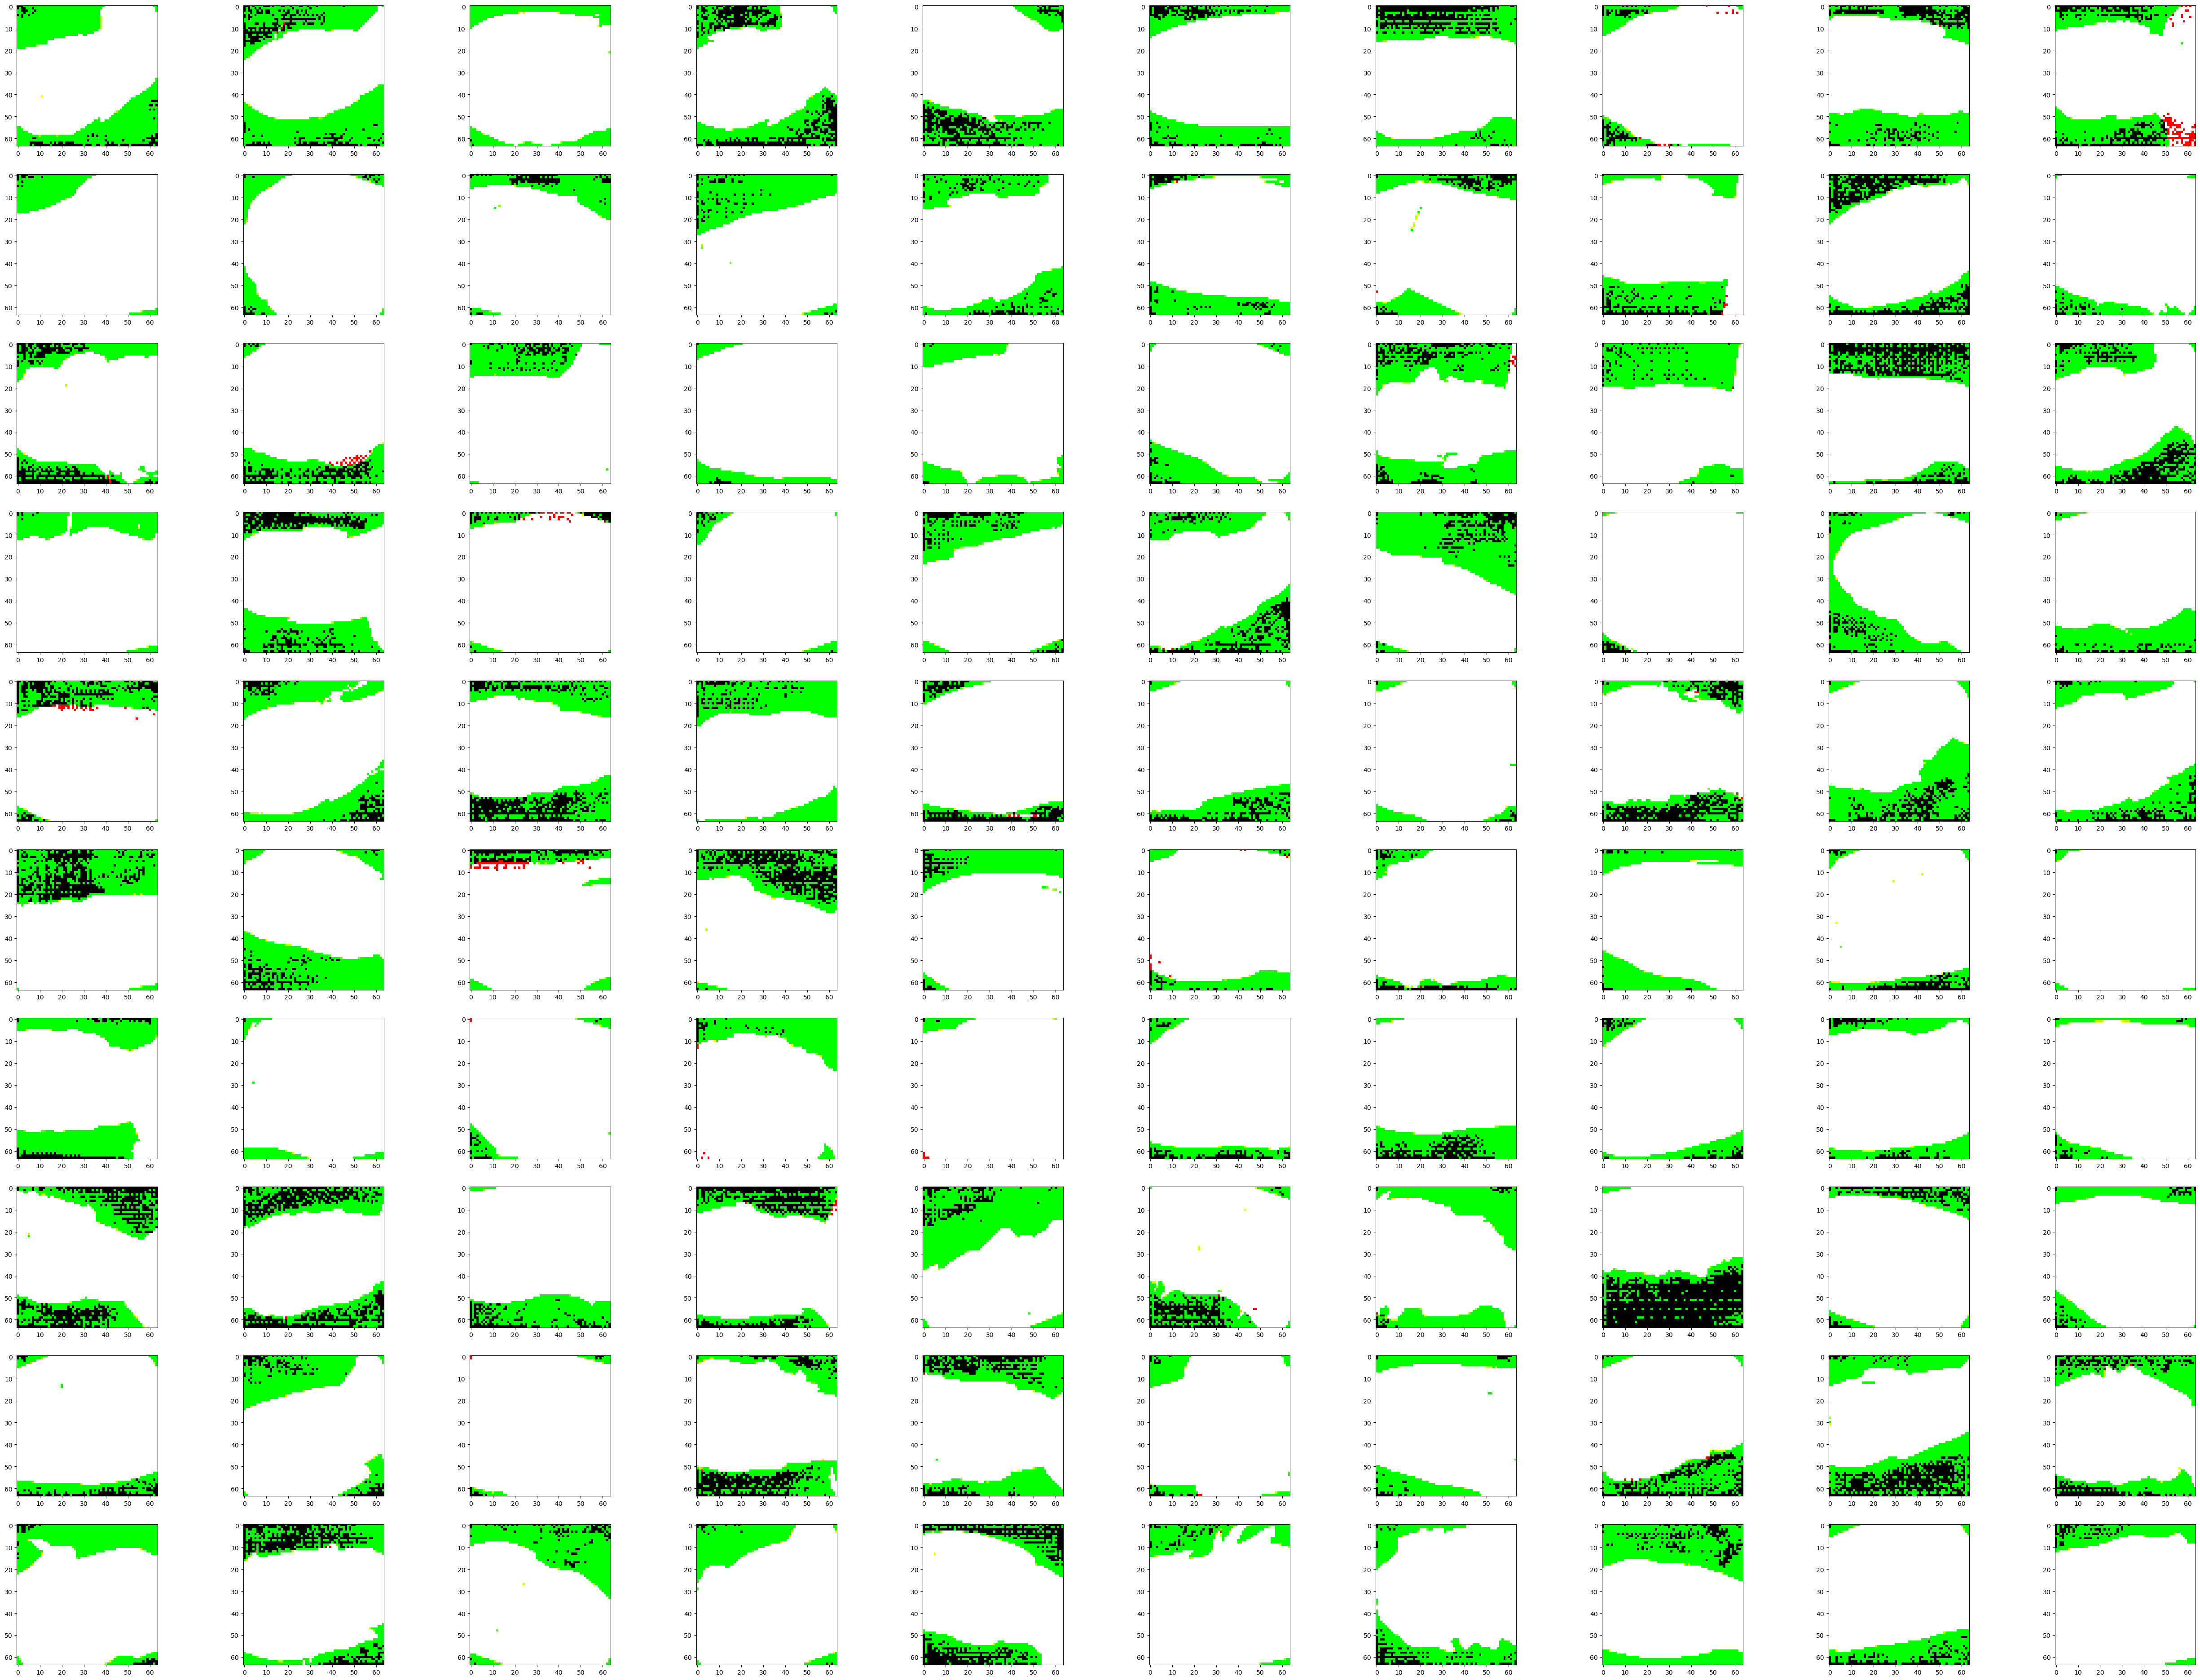

In [33]:
with torch.no_grad():

    features = img.clone().to('cuda:0')
    decoded = model(features)
    fig, ax = plt.subplots(10,10, figsize=(64, 48))
    img2 = torch.round(decoded)
    img1 = features
    for i in range(10):
        for j in range(10): 
            ax[j,i].imshow(vis_iou(y[i+10*j],img2[i+10*j][[1]]).T)
    plt.show()



In [ ]:
torch.save(model.state_dict(),'./unet_2_3_e4.pt')